<a href="https://colab.research.google.com/github/DutchVandaline/Artificial_Intelligence/blob/main/Deep_Learning_Sealant_Problem_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using GAN to handle image unbalance

To handel image unbalance, I need to generate new image. This is the part of OverSampling. SMOTE is for text or numerical data so, I am using GAN on pytorch to generate new images.


This is based on Pytorch GAN from Kaggle : https://www.kaggle.com/code/arturlacerda/pytorch-conditional-gan/notebook

In [ ]:
import torch
import torch.nn
import torchvision

from torch import nn
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
print(f"torch version : {torch.__version__}")

torch version : 2.5.0+cpu


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image

class Silant(Dataset):
    def __init__(self, root_dir='/content/drive/MyDrive/data/train/normal', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # 이미지 파일 확장자 체크를 더 일반화
        valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
        self.image_paths = [os.path.join(self.root_dir, img_name) for img_name in os.listdir(self.root_dir) if img_name.lower().endswith(valid_extensions)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # 이미지 로드 및 RGB로 변환
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, 0  # 노멀 데이터이므로 라벨은 0으로 설정


In [ ]:
dataset = Silant()
image = dataset[0][0]
print(image.size)

(824, 2532)


In [ ]:
transform = transforms.Compose([
        transforms.Resize((633, 206)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = Silant(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         image_size = 3  * 2532 * 824 # 6259104

#         self.model = nn.Sequential(
#             nn.Linear(image_size, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(1024, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(256, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         # 이미지를 1차원 벡터로 변환 (Batch_size, 3 * 824 * 2532)
#         x = x.view(x.size(0), 3  * 2532 * 824)  # 여기서 크기 명확히 지정
#         out = self.model(x)
#         return out.squeeze()


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        image_size = 3 * 633 * 206  # 1/4 크기

        self.model = nn.Sequential(
            nn.Linear(image_size, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 3 * 633 * 206)
        out = self.model(x)
        return out.squeeze()


In [ ]:
# class Generator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # RGB 이미지 크기: 3채널 * 824 * 2532
#         image_size = 3 * 2532 * 824   # 6259104

#         self.model = nn.Sequential(
#             nn.Linear(100, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(1024, 2048),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(2048, 4096),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(4096, image_size),
#             nn.Tanh()
#         )

#     def forward(self, z):
#         out = self.model(z)
#         # 최종 출력 크기를 RGB 이미지로 맞춤 (Batch_size, 3, 824, 2532)
#         return out.view(z.size(0), 3, 2532, 824)


In [ ]:
# 이미지가 커서 안뽑히므로 1/4 크기로 수정
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # 새로운 이미지 크기: 3채널 * 412 * 1266
        image_size = 3 * 633 * 206  # 1/4 크기

        self.model = nn.Sequential(
            nn.Linear(100, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, 4096),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(4096, image_size),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.model(z)
        # 절반 크기의 이미지를 생성 (Batch_size, 3, 633, 206)
        return out.view(z.size(0), 3, 633, 206)



In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_images = generator(z)
    validity = discriminator(fake_images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images):
    d_optimizer.zero_grad()

    real_validity = discriminator(real_images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    z = Variable(torch.randn(batch_size, 100)).to(device)
    fake_images = generator(z)
    fake_validity = discriminator(fake_images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

출력 이미지가 너무 커서 Ram을 전부 사용, Train이 안됨.

Starting epoch 0...
g_loss: 1.4742372035980225, d_loss: 0.9754799008369446


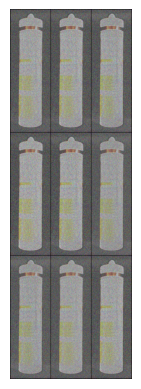

Starting epoch 1...
g_loss: 1.3669776916503906, d_loss: 1.0469218492507935


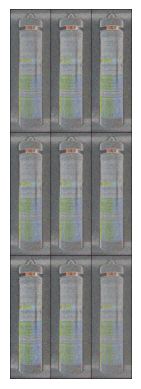

Starting epoch 2...
g_loss: 4.421751022338867, d_loss: 0.2621302604675293


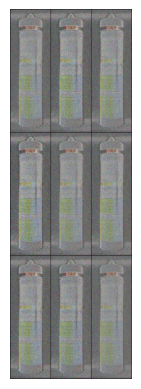

Starting epoch 3...
g_loss: 1.7628494501113892, d_loss: 0.8477805852890015


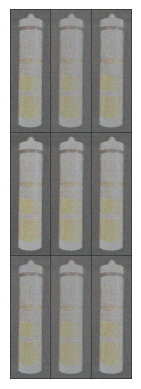

Starting epoch 4...
g_loss: 0.1586838811635971, d_loss: 2.546152114868164


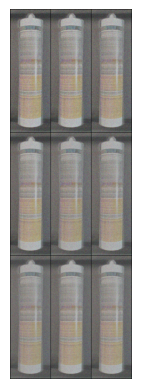

Starting epoch 5...
g_loss: 1.6310428380966187, d_loss: 0.9379044771194458


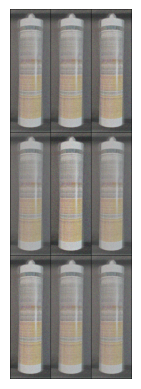

Starting epoch 6...
g_loss: 2.0603811740875244, d_loss: 0.8751450777053833


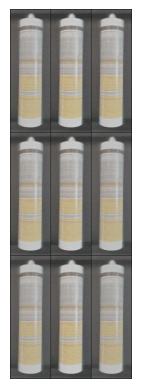

Starting epoch 7...
g_loss: 1.2703900337219238, d_loss: 2.3589563369750977


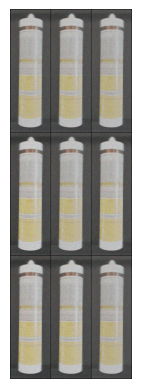

Starting epoch 8...
g_loss: 5.734471321105957, d_loss: 0.5634664297103882


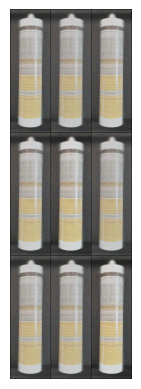

Starting epoch 9...
g_loss: 2.3942465782165527, d_loss: 3.063034772872925


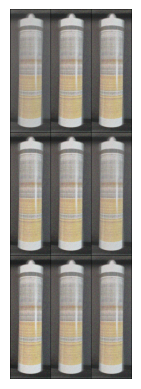

Starting epoch 10...
g_loss: 2.221238851547241, d_loss: 1.5477356910705566


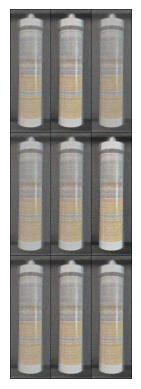

Starting epoch 11...
g_loss: 7.100321292877197, d_loss: 0.13569268584251404


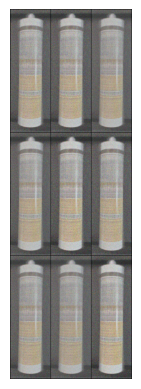

Starting epoch 12...
g_loss: 1.3723808526992798, d_loss: 0.8837541341781616


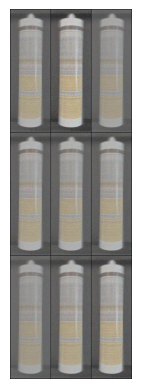

Starting epoch 13...
g_loss: 0.8661090135574341, d_loss: 1.4279359579086304


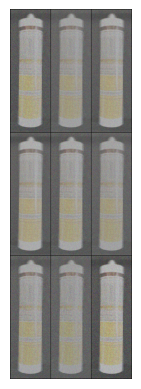

Starting epoch 14...
g_loss: 0.17566072940826416, d_loss: 3.5066540241241455


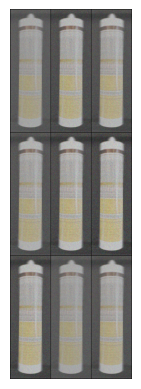

Starting epoch 15...
g_loss: 2.899317502975464, d_loss: 2.9274179935455322


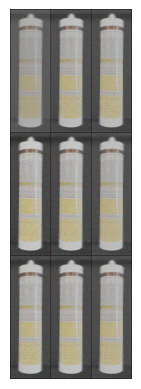

Starting epoch 16...
g_loss: 2.5424964427948, d_loss: 1.6731128692626953


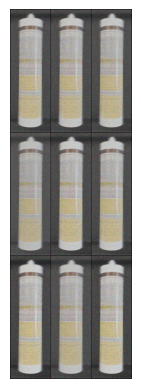

Starting epoch 17...
g_loss: 1.8617799282073975, d_loss: 1.2261052131652832


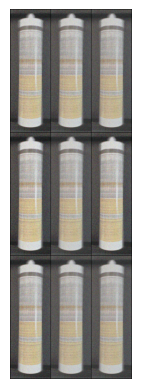

Starting epoch 18...
g_loss: 3.8213179111480713, d_loss: 1.557251214981079


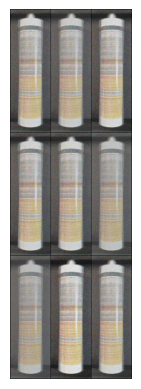

Starting epoch 19...
g_loss: 6.092019081115723, d_loss: 0.3926602900028229


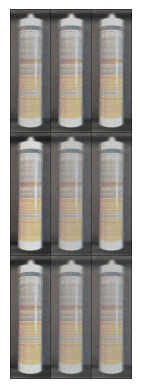

Starting epoch 20...
g_loss: 4.137386798858643, d_loss: 0.26533615589141846


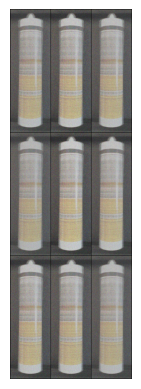

Starting epoch 21...
g_loss: 0.24359244108200073, d_loss: 3.1565346717834473


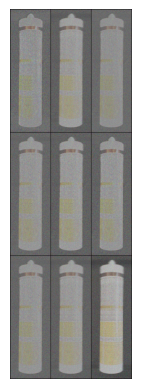

Starting epoch 22...
g_loss: 1.1996557712554932, d_loss: 2.19988751411438


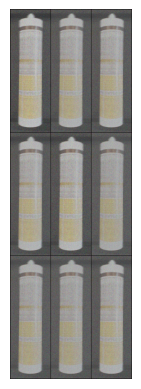

Starting epoch 23...
g_loss: 1.9956767559051514, d_loss: 1.606890320777893


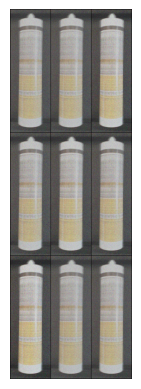

Starting epoch 24...
g_loss: 2.0593149662017822, d_loss: 1.7995513677597046


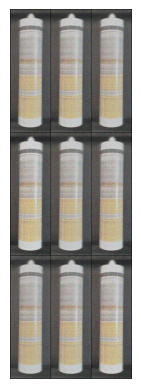

Starting epoch 25...
g_loss: 4.873529434204102, d_loss: 1.218658685684204


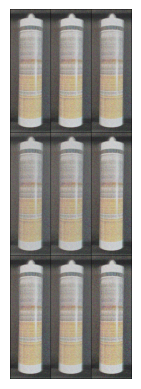

Starting epoch 26...
g_loss: 6.786137580871582, d_loss: 0.21114268898963928


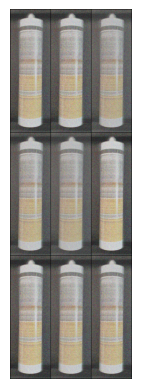

Starting epoch 27...
g_loss: 4.171331405639648, d_loss: 2.4821763038635254


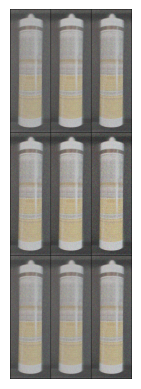

Starting epoch 28...
g_loss: 3.8609347343444824, d_loss: 3.417959690093994


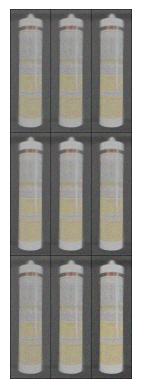

Starting epoch 29...
g_loss: 5.846715927124023, d_loss: 2.130270481109619


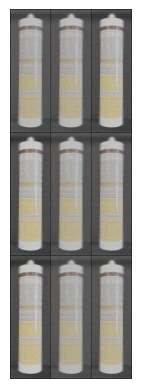

In [ ]:
num_epochs = 30
n_critic = 5
display_step = 300

for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, _) in enumerate(data_loader):
        real_images = Variable(images).to(device)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(batch_size, discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images)

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))

    z = Variable(torch.randn(9, 100)).to(device)
    sample_images = generator(z).data.cpu()

    grid = make_grid(sample_images, nrow=3, normalize=True)

    grid = grid.permute(1, 2, 0).numpy()

    plt.imshow(grid)
    plt.axis('off')
    plt.show()
